# ClusterShearCatalogs stage functionalities

This notebook aims at presenting the `ClusterShearCatalogs` stage of the TXpipe clusters extension. This stage selects background galaxies for each cluster of a cluster catalog and compute basic shear-related quantities for each of those galaxies (e.g., tangential and cross shear components, weights)

In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
# user specific paths -- IN2P3 example
# my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"
my_txpipe_dir = "/pbs/throng/lsst/users/ccombet/TXPipe"

#user specific paths -- NERSC example
#my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# 1 deg$^2$ sample running directly in Jupyter

First we will do some runs on the 1 deg^2 example data set with around 80k galaxies. This is small enough that we can do it all in jupyter.

The data set, which is based on CosmoDC2, contains pre-computed photo-z and and contains a RedMapper cluster catalog for the field.

## This initiates and run the stage

In [4]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterShearCatalogs.config_options)

Options for this pipeline and their defaults:
{'chunk_rows': 100000, 'max_radius': 10.0, 'delta_z': 0.1, 'redshift_criterion': 'mean', 'subtract_mean_shear': True}


In [5]:
pipe_stage = txpipe.extensions.CLClusterShearCatalogs.make_stage(

    # catalogs
    shear_catalog = "data/example/inputs/metadetect_shear_catalog.hdf5",
    cluster_catalog = "./data/example/inputs/cluster_catalog.hdf5",
    source_photoz_pdfs = "data/example/inputs/photoz_pdfs.hdf5",    

    # Initial sample selection was performed and output in shear_tomography_catalog
    # by previously running the TXSourceSelectorMetadetect stage
    shear_tomography_catalog = "data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    
    # Fiducial cosmology: it is needed to get physical distances as we are
    # currently selecting sources based on projected distance (in Mpc) 
    # from cluster center
    fiducial_cosmology = "./data/fiducial_cosmology.yml",
    
    # This is the output for this stage
    cluster_shear_catalogs = "./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    
    # This contains all the options for this stage. Default config options will be updated
    config = "./examples/cosmodc2/config-1deg2-CL.yml",
)

In [6]:
# Check the new config options
pipe_stage.config

StageConfig{chunk_rows:100000,max_radius:5.0,delta_z:0.2,redshift_criterion:mean,subtract_mean_shear:True,shear_catalog:data/example/inputs/metadetect_shear_catalog.hdf5,cluster_catalog:./data/example/inputs/cluster_catalog.hdf5,source_photoz_pdfs:data/example/inputs/photoz_pdfs.hdf5,shear_tomography_catalog:data/example/outputs_metadetect/shear_tomography_catalog.hdf5,fiducial_cosmology:./data/fiducial_cosmology.yml,cluster_shear_catalogs:./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5,config:./examples/cosmodc2/config-1deg2-CL.yml,aliases:{},}

In [7]:
pipe_stage.run()
pipe_stage.finalize()

Min search angle =  10.055618853834702 arcmin
Mean search angle =  12.982302811813245 arcmin
Max search angle =  22.546543656168343 arcmin
Max theta_max = 0.0065585236957462975 radians = 22.546543656168343 arcmin
Using single 2D shear calibration!
Process 0 processing chunk 0 - 82,200
Process 0 done reading
Overall pair count =  65968
Found 954 total galaxies in catalog for cluster 11
Found 826 total galaxies in catalog for cluster 827
Found 792 total galaxies in catalog for cluster 1985
Found 761 total galaxies in catalog for cluster 1632
Found 255 total galaxies in catalog for cluster 2453
Found 933 total galaxies in catalog for cluster 2678
Found 466 total galaxies in catalog for cluster 4643
Found 174 total galaxies in catalog for cluster 5084
Found 746 total galaxies in catalog for cluster 4434
Found 624 total galaxies in catalog for cluster 3939
Found 1457 total galaxies in catalog for cluster 6139
Found 515 total galaxies in catalog for cluster 4709
Found 1402 total galaxies in 

## Checking out the output

To avoid making lots and lots of copies of the data, this stage has not made a catalog, but instead made an index into the other catalogs, and stored only the new derived quantities.

We have a helper class which is designed to match up all the different catalogs that go into this and collect the results for each cluster.

In [27]:
ccc = txpipe.extensions.CombinedClusterCatalog(
    shear_catalog="./data/example/inputs/metadetect_shear_catalog.hdf5",
    shear_tomography_catalog="./data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    cluster_shear_catalogs="./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    photoz_pdfs="./data/example/inputs/photoz_pdfs.hdf5",
)

In [20]:
print(f"We have {ccc.ncluster} clusters")

We have 75 clusters


We can extract the cluster catalog info by index (0 -- 74):

In [21]:
cluster_info = ccc.get_cluster_info(0)
cluster_info

{'cluster_id': 11,
 'dec': -30.89586711375849,
 'ra': 60.69667268260482,
 'redshift': 0.49929956,
 'redshift_err': 0.0029379127,
 'richness': 167.65639,
 'richness_err': 2.9917574,
 'scaleval': 0.99996734}

And also the shear catalog associated with that cluster, again by index, in the CLMM data format

In [26]:
bg_cat = ccc.get_background_shear_catalog(0)
bg_cat[0:3]

ra,dec,e1,e2,weight_clmm,tangential_comp_clmm,cross_comp_clmm,distance_arcmin,weight_original,zmean
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
60.50453842271902,-30.95628376214968,0.030911786224021822,-0.37270744999790895,9.325821260399727e-31,-582877124896605.5,580802751890670.1,10.532585641243355,1.0,1.6672548870541304
60.769936503988525,-30.803768581493113,-0.19068023722048472,-0.17377512271094686,9.717169154876238e-31,-498275609021567.75,246858718016259.6,6.691628009493257,1.0,1.756284729977865
60.768679749598526,-30.79745847728931,-0.3006557955178168,0.44979494313286433,8.494567650500435e-31,633999009218739.2,1074094856718668.0,6.972947511693435,1.0,1.5009352447802593


# 20 deg$^2$ example using the pipeline approach

In [11]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/Cluster_pipelines/CLClusterShearCat-20deg2-CL.yml"
flowchart_file = "CLClusterShearCat.png"

pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)


0

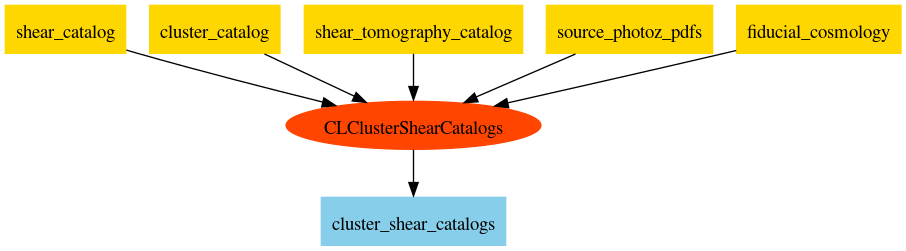

In [12]:
Image(flowchart_file)